In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  mean_squared_error 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings(action='ignore')

# Data Preprocessing

In [2]:
priceData = pd.read_csv("./data/processed/pricesList.csv")
rainfallData = pd.read_csv("./data/processed/rainfallData.csv")

In [3]:
u_priceData = priceData.copy()
# iterate through the rainfallData and add the rainfall to the priceData
for index, row in rainfallData.iterrows():
    # match the year and month from the rainfall data to the pricedata
    year = row['year']
    month = row['month']
    u_priceData.loc[(u_priceData['Year'] == year) & (u_priceData['Month'] == month), 'anuradhapura'] = row['anuradhapura']
    u_priceData.loc[(u_priceData['Year'] == year) & (u_priceData['Month'] == month), 'jaffna'] = row['jaffna']
    u_priceData.loc[(u_priceData['Year'] == year) & (u_priceData['Month'] == month), 'nuwaraeliya'] = row['nuwaraeliya']

In [4]:
df = u_priceData.copy()
def preprocess_input(df):
    df = df.copy()

    # Drop rows with missing values if any
    df.dropna(inplace=True)

    # Split df into X and y
    X = df.drop("Price", axis=1)
    Y = df["Price"]

    return X, Y
X, Y = preprocess_input(df)

In [24]:
# Preprocessing pipeline
numeric_features = ['Week', 'Month', 'Year', 'anuradhapura', 'jaffna', 'nuwaraeliya']
categorical_features = ['Name', 'Season']

numeric_transformer = Pipeline(steps=[
    ('num', 'passthrough')])  # No transformation needed for numeric features

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
regression_model = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', RandomForestRegressor())])

In [9]:
regression_model.fit(X, Y)
accuracy = regression_model.score(X, Y)
print("Accuracy:", accuracy*100)

Accuracy: 99.90345863362523


In [31]:
def get_user_input():
    name = input("Enter the name of the item: ")
    week = int(input("Enter the week: "))
    month = int(input("Enter the month: "))
    year = int(input("Enter the year: "))
    if month in range(3, 5):
        season = "First Inter-monsoon Season"
    elif month in range(5, 10):
        season = "South-West Monsoon Season"
    elif month in range(10, 12):
        season = "Second Inter-monsoon Season"
    else:
        season = "North-East Monsoon Season"
    anuradhapura = float(input("Enter the rainfall in Anuradhapura: "))
    jaffna = float(input("Enter the rainfall in Jaffna: "))
    nuwaraeliya = float(input("Enter the rainfall in Nuwara Eliya: "))
    return {"Name": name, 'Week': week, 'Month': month, 'Year': year, 'Season': season, 'anuradhapura': anuradhapura, 'jaffna': jaffna, 'nuwaraeliya': nuwaraeliya}


In [33]:
user_data = get_user_input()
user_df = pd.DataFrame([user_data])
predicted_price = regression_model.predict(user_df)

# Display prediction
print("Predicted price:", predicted_price[0])

Predicted price: 382.0575018472317


<Axes: ylabel='Price'>

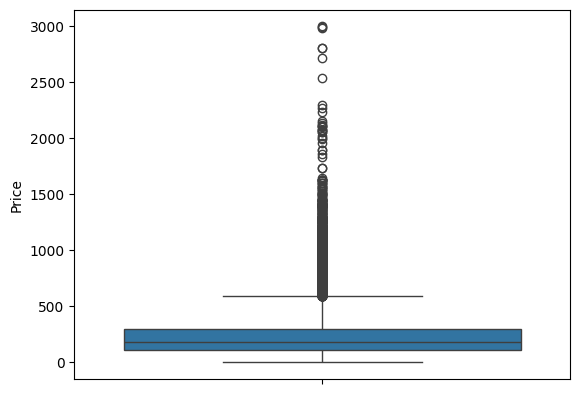

In [7]:
import seaborn as sns
data2 = df.copy()
data2.dropna()
sns.boxplot(data2["Price"])

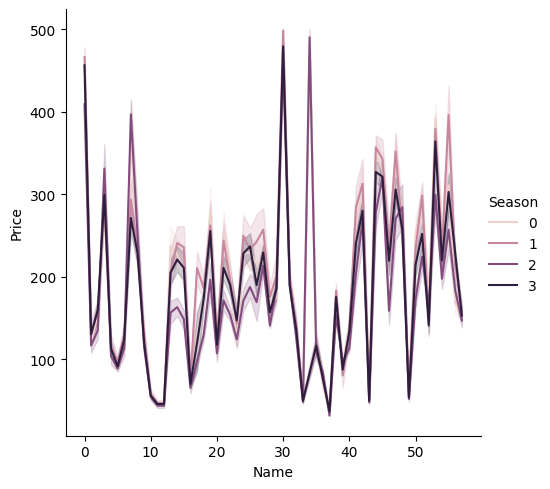

In [45]:
import plotly.express as px
sns.relplot(data=data2, x="Name", y="Price", hue="Season", kind="line")

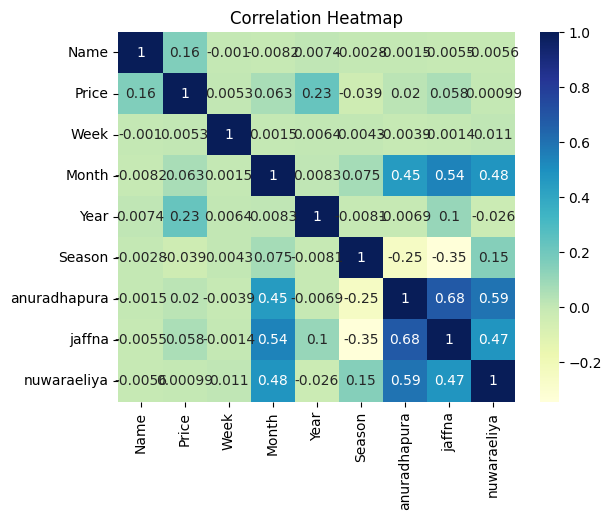

In [40]:
import matplotlib.pyplot as plt
dist = data2["Name"]
distset = set(dist)
dd = list(distset)
dictOfWords = { dd[i] : i for i in range(0, len(dd) ) }
data2["Name"] = data2["Name"].map(dictOfWords)

dist = (data2["Season"])
distset = set(dist)
dd = list(distset)
dictOfWords = { dd[i] : i for i in range(0, len(dd) ) }
data2["Season"] = data2["Season"].map(dictOfWords)

plt.title('Correlation Heatmap')
dataplot = sns.heatmap(data2.corr(), cmap="YlGnBu", annot=True)

plt.show()

# Test

In [10]:
import numpy as np

In [11]:
data2 = df.copy()
data2 = data2.dropna()

In [12]:
data2.shape

(15768, 9)

In [13]:
data2["Price"]

0        135.15
1        111.11
2        112.86
3         99.39
4        228.57
          ...  
16699    235.45
16700    279.13
16701    471.74
16702    359.05
16703    532.63
Name: Price, Length: 15768, dtype: float64

In [14]:
# IQR
Q1 = np.percentile(data2["Price"], 25, interpolation = 'midpoint')
Q3 = np.percentile(data2["Price"], 75, interpolation = 'midpoint')
IQR = Q3 - Q1

In [15]:
# Upper bound
upper = np.where(data2["Price"] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(data2["Price"] <= (Q1-1.5*IQR))
print(upper[0], lower[0])

[   17    72   187 ... 15747 15751 15767] []


In [16]:
data2.reset_index(inplace=True, drop=True)

# Removing the outliers
data2.drop(upper[0], inplace=True)
data2.drop(lower[0], inplace=True)

print("New Shape: ", data2.shape)

New Shape:  (14550, 9)


<Axes: title={'center': 'Box plot after outlier removal'}, ylabel='Price'>

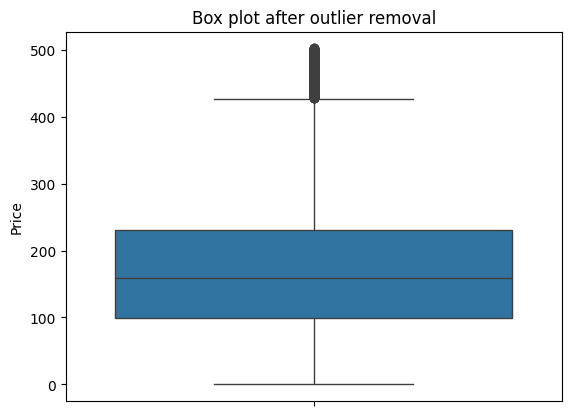

In [39]:
plt.title("Box plot after outlier removal")
sns.boxplot(data2["Price"])

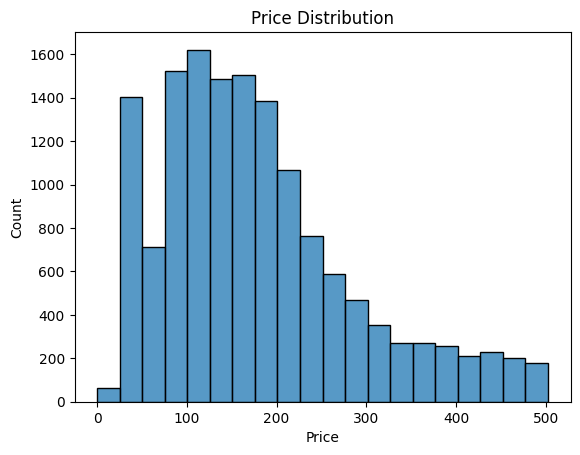

In [38]:
plt.title('Price Distribution')
sns.histplot(data=data2, x="Price", bins=20)

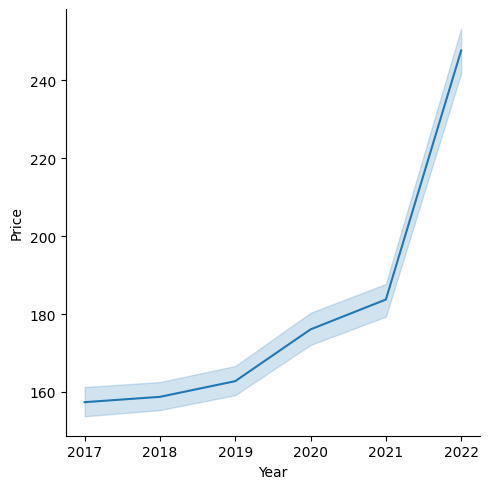

In [50]:
# Line plot of Price over Years
sns.relplot(data=data2, x="Year", y="Price", kind="line")

In [20]:
df = data2.copy()


X_train, X_test, Y_train, Y_test = preprocess_input(df)

In [25]:
regression_model = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', RandomForestRegressor(bootstrap=True, criterion='poisson',max_depth=None, max_leaf_nodes=None,n_estimators=250, random_state=None, n_jobs=1, verbose=0))])
regression_model.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   'passthrough')]),
                                                  ['Week', 'Month', 'Year',
                                                   'anuradhapura', 'jaffna',
                                                   'nuwaraeliya']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Name', 'Season'])])),
                ('regressor',
                 RandomForestRegressor(criterion='poisson', n_estimators=250,
                                       n_jobs=1))])

In [28]:
regression_model = Pipeline(steps=[('preprocessor', preprocessor),
                                      ('regressor', CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.25, loss_function='RMSE'))])
regression_model.fit(X_train, Y_train)

0:	learn: 99.4219301	total: 51.8ms	remaining: 8m 37s
1:	learn: 92.3983513	total: 55.3ms	remaining: 4m 36s
2:	learn: 85.9067549	total: 58.1ms	remaining: 3m 13s
3:	learn: 81.6240146	total: 60.5ms	remaining: 2m 31s
4:	learn: 78.9484025	total: 63.5ms	remaining: 2m 6s
5:	learn: 75.7880319	total: 66.4ms	remaining: 1m 50s
6:	learn: 73.6991335	total: 70.1ms	remaining: 1m 40s
7:	learn: 71.2409805	total: 73.3ms	remaining: 1m 31s
8:	learn: 69.2726748	total: 76.7ms	remaining: 1m 25s
9:	learn: 67.5686798	total: 79.6ms	remaining: 1m 19s
10:	learn: 66.1882364	total: 82.4ms	remaining: 1m 14s
11:	learn: 63.5792454	total: 85.8ms	remaining: 1m 11s
12:	learn: 61.9903163	total: 89.3ms	remaining: 1m 8s
13:	learn: 60.3595971	total: 92.2ms	remaining: 1m 5s
14:	learn: 59.0311044	total: 94.8ms	remaining: 1m 3s
15:	learn: 57.7539257	total: 97.7ms	remaining: 1m
16:	learn: 56.6914754	total: 102ms	remaining: 59.7s
17:	learn: 55.8342897	total: 105ms	remaining: 58.1s
18:	learn: 54.6837143	total: 107ms	remaining: 56.4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   'passthrough')]),
                                                  ['Week', 'Month', 'Year',
                                                   'anuradhapura', 'jaffna',
                                                   'nuwaraeliya']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Name', 'Season'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f0d5c1405e0>)])

In [29]:
accuracy = regression_model.score(X_test, Y_test)
print("Accuracy:", accuracy)
Y_pred = regression_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

Accuracy: 0.9540486214482314
MSE: 550.5175736955647
RMSE: 23.46311091257007


In [30]:
regression_model.fit(X_test, Y_test)
accuracy = regression_model.score(X_test, Y_test)
print("Accuracy:", accuracy)
Y_pred = regression_model.predict(X_test)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

0:	learn: 101.1387247	total: 2.87ms	remaining: 28.7s
1:	learn: 95.6008374	total: 5.75ms	remaining: 28.8s
2:	learn: 89.7225069	total: 8.11ms	remaining: 27s
3:	learn: 86.3183801	total: 10.5ms	remaining: 26.2s
4:	learn: 84.0701469	total: 12.6ms	remaining: 25.1s
5:	learn: 80.9004943	total: 15ms	remaining: 24.9s
6:	learn: 78.3005471	total: 17.8ms	remaining: 25.4s
7:	learn: 75.5876349	total: 19.9ms	remaining: 24.8s
8:	learn: 73.8373841	total: 22.4ms	remaining: 24.8s
9:	learn: 71.9088893	total: 25ms	remaining: 25s
10:	learn: 70.5179003	total: 27.4ms	remaining: 24.9s
11:	learn: 68.8810922	total: 29.4ms	remaining: 24.4s
12:	learn: 67.6560393	total: 31.2ms	remaining: 24s
13:	learn: 65.6781771	total: 34.2ms	remaining: 24.4s
14:	learn: 64.2127321	total: 37.4ms	remaining: 24.9s
15:	learn: 62.8730393	total: 40.9ms	remaining: 25.5s
16:	learn: 61.8517973	total: 43.3ms	remaining: 25.5s
17:	learn: 60.2644578	total: 45.4ms	remaining: 25.2s
18:	learn: 59.1775704	total: 47.6ms	remaining: 25s
19:	learn: 58.

In [ ]:
import pickle
# Save the model as a pickle file
filename = './models/test_model.sav'
pickle.dump(regression_model, open(filename, 'wb'))

In [19]:
def preprocess_input(df):
    df = df.copy()

    # Drop rows with missing values if any
    df.dropna(inplace=True)

    # Split df into X and y
    X = df.drop("Price", axis=1)
    Y = df["Price"]

    # Train-test split
    X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.3, shuffle=True)

    return X_train, X_test, Y_train, Y_test

In [ ]:
# Take a look at the class/breed distribution
ax=pd.value_counts(data2['Name'],ascending=True).plot(kind='barh',fontsize="10",title="Veges Distribution",figsize=(20,30),color=["red","green","blue","orange","purple","pink"])
ax.set(xlabel="counts", ylabel="Vegetables")
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.title.set_size(10)
plt.show()

In [ ]:
data2.head()